<a href="https://colab.research.google.com/github/danielmlow/tutorials/blob/main/speech/speech_shaped_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech-shaped noise

**Author: Daniel Low**


Noise shaped with speech's amplitude. Impose intensity contour (influenced by syllable rate, phonetic structure). 

Not recommended to do with single word, because the strongest segment might be the vowel. So the noise will sound like the vowel and its spectrum will look like the vowel's spectrum.

Steps:
1. Load target audio
2. Apply Hilbert transform to extract envelope.
3. Create noise to match long term speech spectrum
4. Multiply envelope x noise to obtain 

A `more ideal noise generator` could involve a filterbank approach to the segment the audio and noise into separate channels using filters, extracting the envelope from each filtered response, and using it modulate the filtered noise. Then recombining all the filtered noise channels back into an audio stream.

This would be more analogous to how the ear processes sound. Perhaps using something like https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html

In [ ]:
import os 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from IPython.display import display, Audio

import numpy as np
from scipy import signal
from scipy.io import wavfile
from sklearn.preprocessing import MinMaxScaler


In [ ]:
from google.colab import drive
# Get access to Google Drive and attach it to the colab for data I/O. Follow instructions:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# figure config
plt.rcParams['figure.figsize'] = [12, 2]
plt.rcParams['figure.dpi'] = 120

In [ ]:
def speech_shaped_noise(path_to_wav,noise=None,scale_envelope = True, filter_envelope=True, gen_figures=True, play_audio=True,save_audio=False, output_path = None):
  # signal
  print('\n\n====='+path_to_wav)
  sr, data = wavfile.read(path_to_wav)
  print('samplig rate: ',sr)
  data = data [:,0].flatten() #extract single channel
  duration = len(data)/sr
  time = np.arange(0,duration,1/sr) #time vector
  scaler = MinMaxScaler()
  if gen_figures:
    plt.plot(time,data)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title(path_to_wav)
    plt.show()
  if play_audio:
    display(Audio(data=data.T, rate=sr, autoplay=False))
  
  # Envelope: extract amplitude envelope through Hilbert transform https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
  analytic_signal = signal.hilbert(data)
  amplitude_envelope = np.abs(analytic_signal)
  if filter_envelope: # to capture slower speech rate frequencies instead of pitch period
    sos = signal.butter(20, 50, 'lp', fs=sr, output='sos')
    amplitude_envelope = signal.sosfiltfilt(sos, amplitude_envelope)
  if scale_envelope:
    amplitude_envelope_before_scaling = amplitude_envelope.copy()
    amplitude_envelope = scaler.fit_transform(amplitude_envelope.reshape((-1, 1))).flatten()
  if gen_figures:
    t = np.arange(len(data)) / sr
    plt.plot(t, data, label='signal')
    plt.plot(t, amplitude_envelope_before_scaling, label='filtered envelope unscaled', c='orange',linestyle='dashed', alpha=0.5)
    plt.xlabel("time in seconds")
    plt.legend()
    plt.xlim((0.3,2))
    plt.title('Signal and amplitude envelope through Hilbert transform\nNote: envelope is later scaled to (0,1)')
    plt.show()
  
  # Noise: generate if noise == None, else load noise from argument
  if noise is None: 
    print('generating noise...')
    num_samples = len(data)
    noise = np.random.rand(num_samples)*2-1
    noise = np.real(np.fft.ifft(np.abs(np.fft.fft(data))*np.fft.fft(noise)))
  if gen_figures:
    plt.plot(noise)
    plt.title('Speech noise: noise made from adding 30-sec random clips from 10m interview recording (zoomed in, 30 sec total)')
    plt.show()

  noise_matched_length = noise[:data.shape[0]] # Take a segment of noise of similar length as audio
  if play_audio:
      display(Audio(data=noise_matched_length.T, rate=sr, autoplay=False))
  
  # Speech shaped noise
  speech_shaped_noise = noise_matched_length*amplitude_envelope
  if gen_figures:
    plt.plot(speech_shaped_noise)
    plt.title('Speech-shaped noise')
    plt.show()
  display(Audio(data=speech_shaped_noise.T, rate=sr, autoplay=False))
  if save_audio:
    wavfile.write(output_path+".wav",sr, speech_shaped_noise.astype(np.int16))

  if gen_figures:
    # Plot Speech spectrum
    start =-100
    end=100
    plt.magnitude_spectrum(data, Fs=sr, scale='dB', color='C1')
    plt.title("Log. Magnitude Spectrum - Speech")
    # plt.ylim(start,end) 
    plt.xlim(0,6000) 
    plt.show()

    # Plot Speech spectrum
    plt.magnitude_spectrum(noise_matched_length, Fs=sr, scale='dB', color='C1')
    plt.title("Log. Magnitude Spectrum - Noise")
    # plt.ylim(start,end) 
    plt.xlim(0,6000) 
    plt.show()
    
    # Plot Speech-shaped noise spectrum
    plt.magnitude_spectrum(speech_shaped_noise, Fs=sr, scale='dB', color='C1')
    plt.title("Log. Magnitude Spectrum - Speech-shaped noise")
    # plt.ylim(start,end) 
    plt.xlim(0,6000)
    plt.show()



=====/content/drive/My Drive/datum/umass/stimuli/TR_04_OwlBabies Clip.wav
samplig rate:  44100


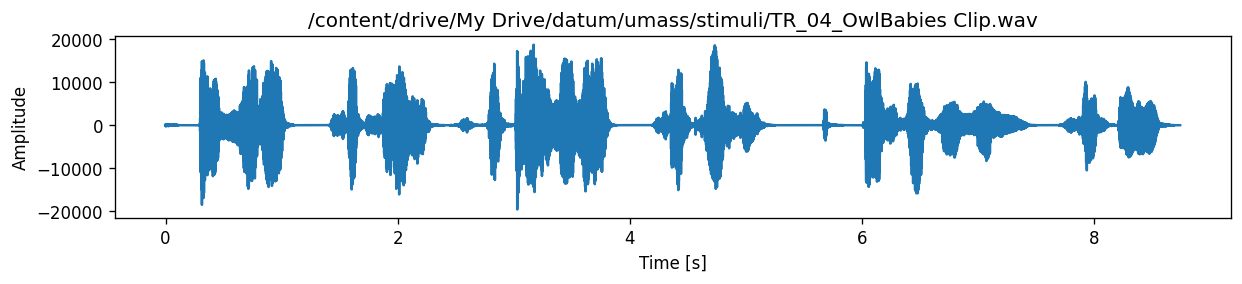

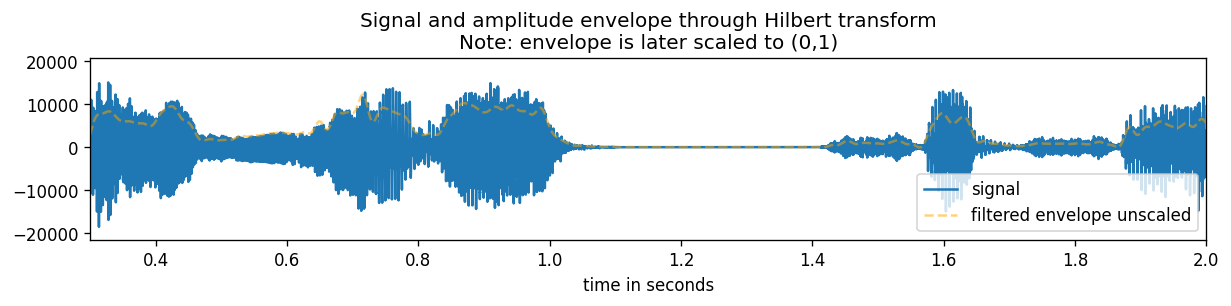

generating noise...


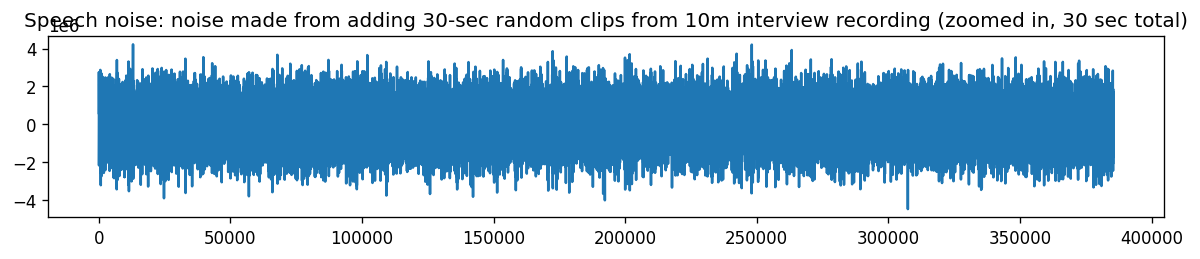

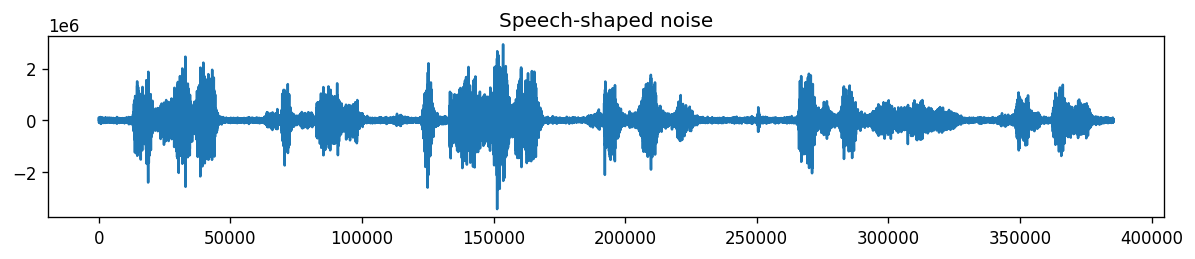

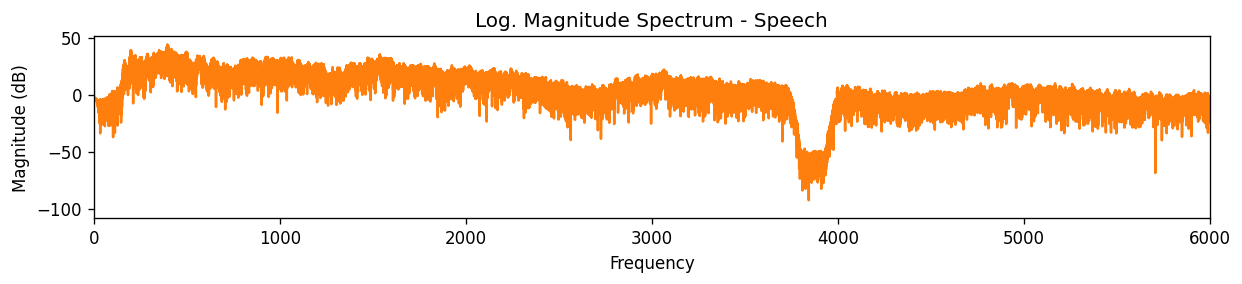

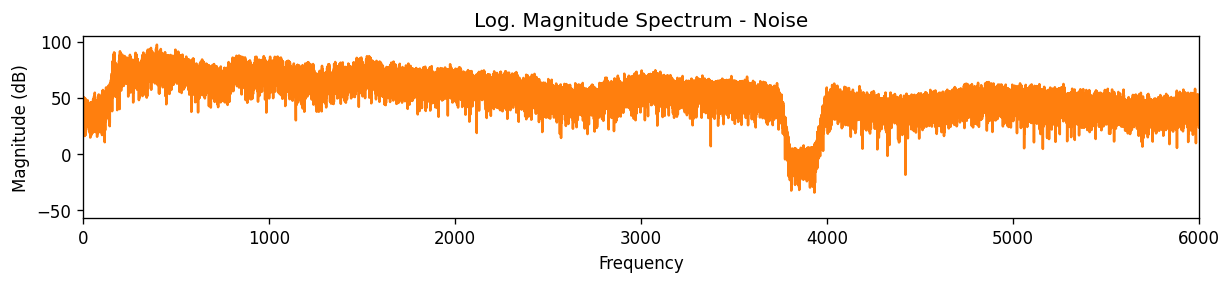

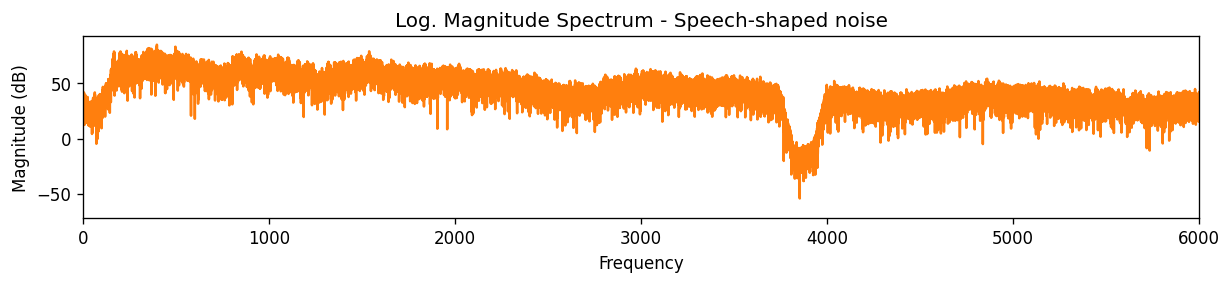

In [ ]:
speech_shaped_noise('/content/drive/My Drive/datum/umass/stimuli/TR_04_OwlBabies Clip.wav',
                    noise=None, #speech_noise,
                    scale_envelope = True, 
                    filter_envelope = True, 
                    gen_figures=True, 
                    play_audio=True, 
                    save_audio=False, 
                    )

In [ ]:
# Make speech-shaped noise from target audio recording
input_dir='/content/drive/My Drive/datum/umass/stimuli/' #CHANGE TO YOUR PATH
output_dir='/content/drive/My Drive/datum/umass/speech_shaped_noise/' #CHANGE TO YOUR PATH

os.makedirs(output_dir, exist_ok=True)

wav_files = os.listdir(input_dir) #for now: ['TR_04_OwlBabies Clip.wav']

for wav_file in wav_files:
    print(wav_file)
    speech_shaped_noise(input_dir+wav_file, 
                      noise=None, 
                      scale_envelope = True, 
                      filter_envelope = True,
                      gen_figures=False, 
                      play_audio=False, 
                      save_audio=True, 
                      output_path = output_dir+wav_file[:-4]
                      )

TR_04_OwlBabies Clip.wav


=====/content/drive/My Drive/datum/umass/stimuli/TR_04_OwlBabies Clip.wav
samplig rate:  44100
generating noise...
